In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
# Load local modules
import sys
sys.path.append('d:\\Users\\serfe\\Documents\\GitHub\\seisinv\\src')
from basic_ops_seis_inv import Filtering, ConversionTool, MathOps, Error
from tqdm import tqdm

c:\Users\serfe\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


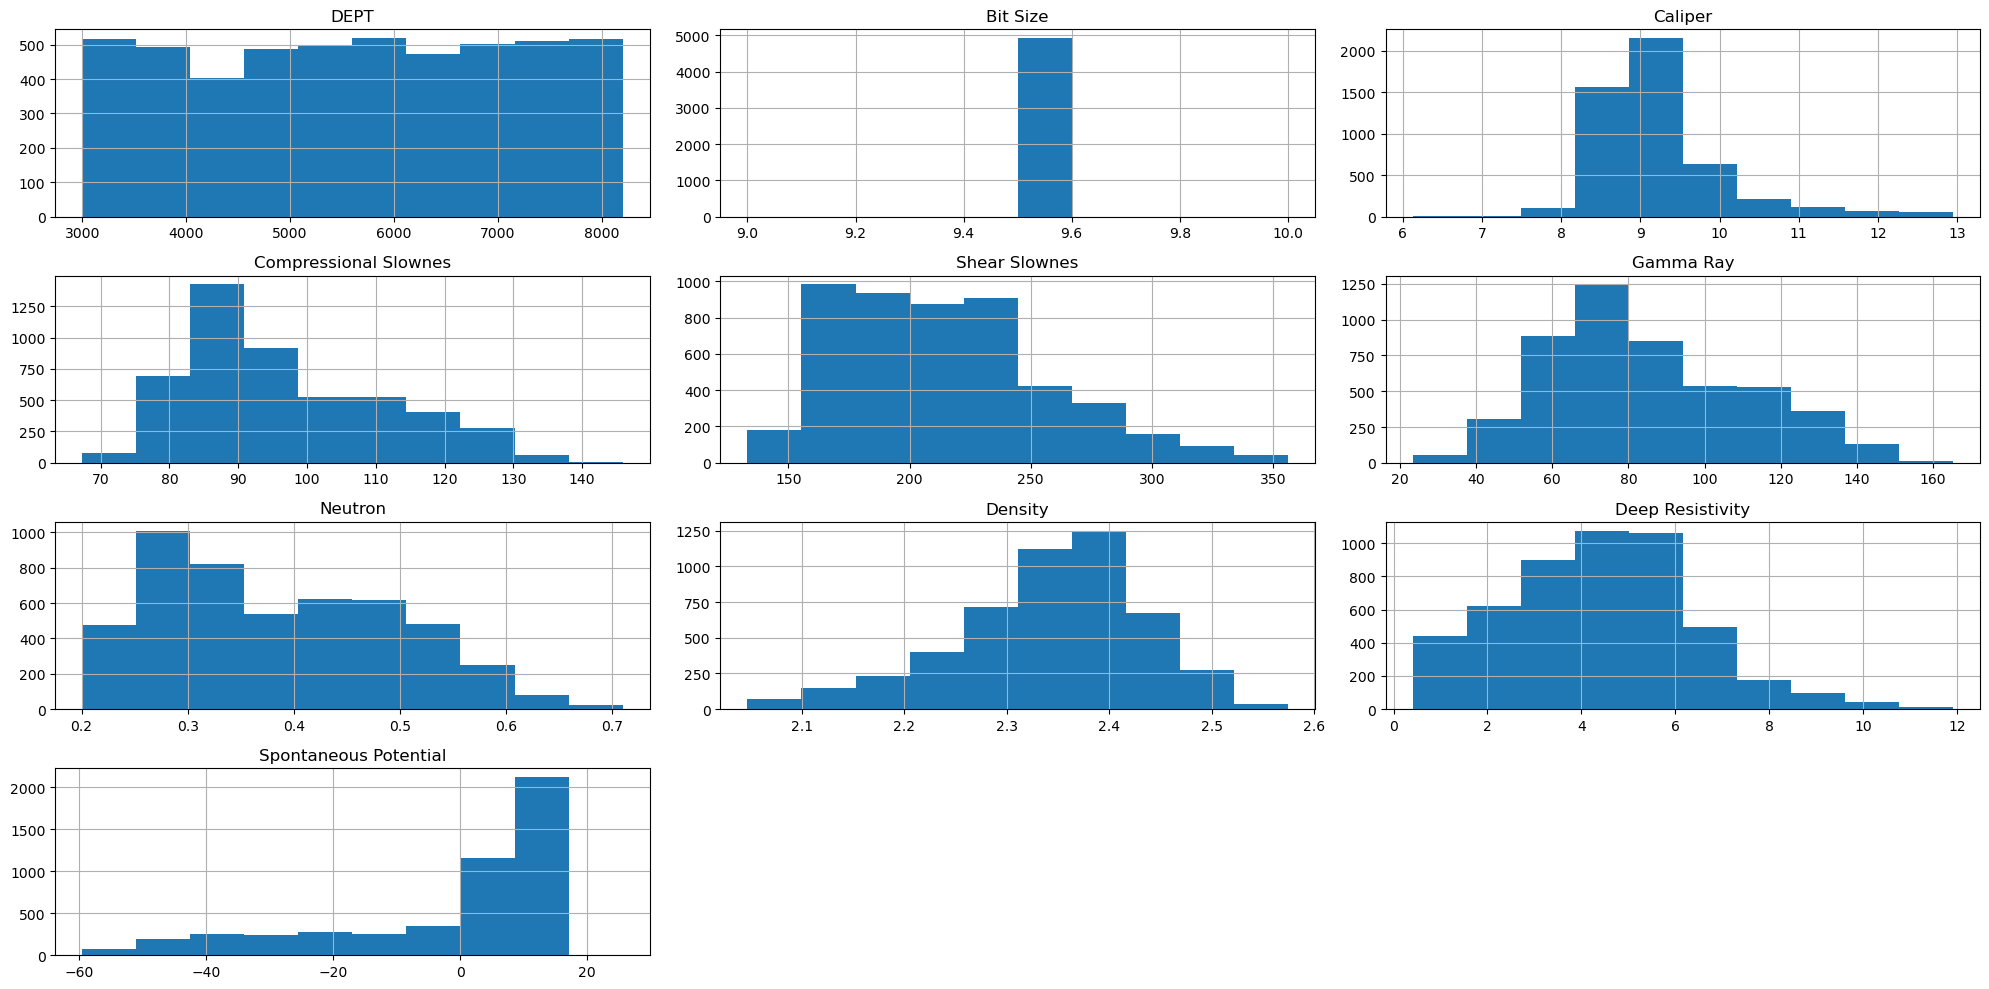

In [2]:
# Load data
path_data = 'd:\\Users\\serfe\\Documents\\GitHub\\seisinv\\data\\Task2_data.xlsx'
df = pd.read_excel(path_data)
# Remove outliers
df = Filtering().remove_outliers(df, drop_col=['Surface', 'Bit Size'])
# Plot data
df.hist(figsize=(20,10))
plt.tight_layout()

In [3]:
# Backus conversion to seismic domain
vp = (1 / ConversionTool().SI_conversion(df['Compressional Slownes'], 'micros/ft'))/1000
vs = (1 / ConversionTool().SI_conversion(df['Shear Slownes'], 'micros/ft'))/1000
rho = (ConversionTool().SI_conversion(df['Density'], 'g/cm3'))/1000
depth = df['DEPT']
vp0, vs0, rho0, dept0 = ConversionTool(104, vp, vs, rho, 3000, depth).backus_downsampling()

Output units: kg/m3
Original sampling frequency (in well-log domain) is: 14853.21312132847 Hz
New sampling frequency (in seismic domain) is: 119.49768920340405 Hz


Text(0.5, 1.0, 'Backus conversion: From Well-log domain to Seismic domain')

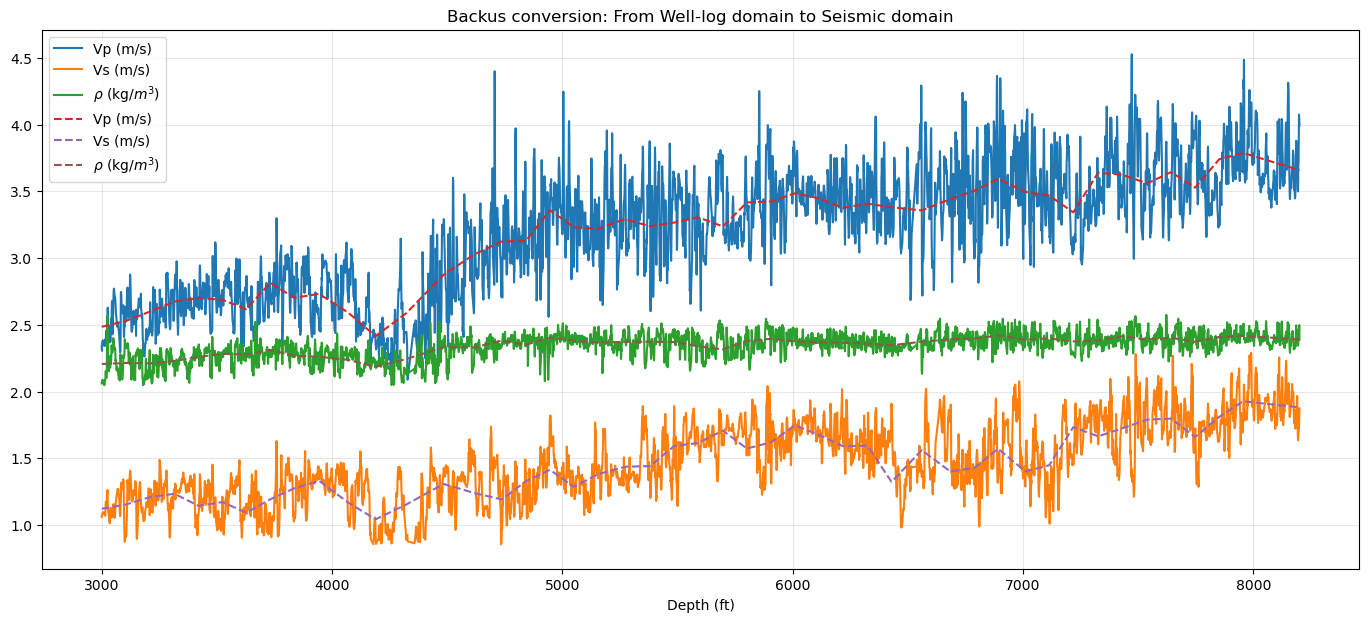

In [4]:
# Plot resmapled data
fig = plt.figure(figsize=(17,7))
plt.plot(df.DEPT, vp, label='Vp (m/s)')
plt.plot(df.DEPT, vs, label='Vs (m/s)')
plt.plot(df.DEPT, rho, label=fr'$\rho$ (kg/$m^3$)')
plt.plot(dept0, vp0, label='Vp (m/s)', linestyle='dashed')
plt.plot(dept0, vs0, label='Vs (m/s)', linestyle='dashed')
plt.plot(dept0, rho0, label=fr'$\rho$ (kg/$m^3$)', linestyle='dashed')
plt.xlabel('Depth (ft)')
plt.grid(alpha=.3)
plt.legend(ncol=1)
plt.title('Backus conversion: From Well-log domain to Seismic domain')

# Seismic Genetic Inversion

Text(0, 0.5, 'Depth (ft)')

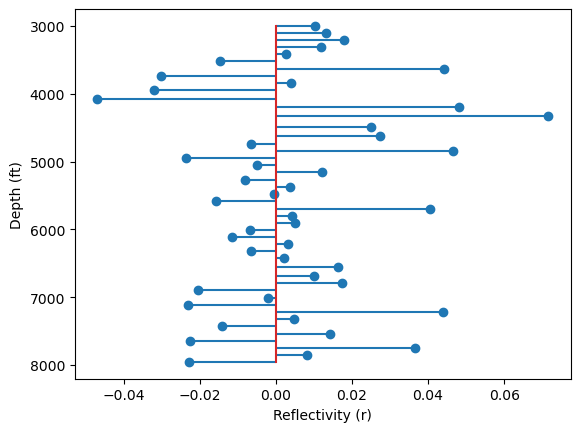

In [5]:
# Calculate the original reflectivity profile (obtained from well-log to seismic domain)
math_ops = MathOps(vp=vp0, rho=rho0)
Z = math_ops.calc_impedance()
r = math_ops.calc_r(Z_data=Z)
plt.stem(dept0[:-1], r, orientation='horizontal')
plt.gca().invert_yaxis()
plt.xlabel('Reflectivity (r)')
plt.ylabel('Depth (ft)')

In [6]:
print(f'There are {len(vp0)} samples in the new seismic domain.')

There are 47 samples in the new seismic domain.


We will create 100000 random models with some constrains for $v_p$, $v_s$ and $\rho$. As there are 47 samples, we will create 47 gens, that will form a chromosome. The folllowing is an example of 1 chromosome formed by 47 gens. The way we build the initial random models is by creating a linear space similar to a line with a positive slope, because Vp, Vs and rho tend to increase with depth. However as we want the models to be random, we add some random noise to allow randomness.

In [7]:
# Define the number of layers and the number of realizations
num_layers = 47
num_realizations = 100000

# Define the constraints
min_rho = 2.1
max_rho = 2.8
min_vs = 1.0
max_vs = 2.0
min_vp = 2.4
max_vp = 3.8
max_diff = 0.3  # Maximum difference between adjacent values

# Initialize arrays to store the random values
rho_gen = np.zeros((num_layers, num_realizations))
vs_gen = np.zeros((num_layers, num_realizations))
vp_gen = np.zeros((num_layers, num_realizations))

# Generate the base sequence of values within the constraints
base_rho = np.linspace(min_rho, max_rho, num_layers)
base_vs = np.linspace(min_vs, max_vs, num_layers)
base_vp = np.linspace(min_vp, max_vp, num_layers)

# Perturb the base sequence to ensure adjacent values are within max_diff
for i in range(num_realizations):
    perturbation_rho = np.random.uniform(-max_diff, max_diff, num_layers)
    perturbation_vs = np.random.uniform(-max_diff, max_diff, num_layers)
    perturbation_vp = np.random.uniform(-max_diff, max_diff, num_layers)
    
    rho_gen[:, i] = base_rho + perturbation_rho
    vs_gen[:, i] = base_vs + perturbation_vs
    vp_gen[:, i] = base_vp + perturbation_vp

# Clip the values to stay within the constraints
rho_gen = np.clip(rho_gen, min_rho, max_rho)
vs_gen = np.clip(vs_gen, min_vs, max_vs)
vp_gen = np.clip(vp_gen, min_vp, max_vp)

# Round all values to two decimal places
rho_gen = np.round(rho_gen, 2)
vs_gen = np.round(vs_gen, 2)
vp_gen = np.round(vp_gen, 2)

In [8]:
# One chromosome from 10000 possible chromosomes
# Each cell/row is a gen
def one_chromosome(n_chromosome=0, print_=False):
    rho_chromosome = rho_gen[:,n_chromosome]
    vp_chromosome = vp_gen[:,n_chromosome]
    vs_chromosome = vs_gen[:,n_chromosome]
    chromosome = np.stack([rho_chromosome, vp_chromosome, vs_chromosome], axis=1)
    # Now let's calculate the reflectivity profile for the chromosome
    math_ops = MathOps(vp=vp_chromosome, rho=rho_chromosome)
    Z_chromosome = math_ops.calc_impedance()
    r_chromosome = math_ops.calc_r(Z_data=Z_chromosome)
    # Now compare the real reflectivity profile with the generic one.
    error = Error(y_true=r, y_pred=r_chromosome)
    l1_error, l2_error = error.l1_error(), error.l2_error()

    if print_:
        print(fr'The columns are: $\rho$, $v_p$, $v_s$')
        print('Example of 1 chromoosme with 47 gens', '\n')
        print(chromosome)
        print('Errors between original and chromosome reflectivity profiles.', '\n')
        print(f'l1 error: {l1_error}%')
        print(f'l2 error: {l2_error}%')
    
    if l1_error <= 5:
        return l1_error, l2_error, chromosome
    else:
        return 9999, 9999, 9999

The following is an example of 1 chromosome. The error between teh chromosome and the observed reflectivity profile is calculated.

In [9]:
l1_error, l2_error, chromosome = one_chromosome( n_chromosome=0, print_=True)

The columns are: $\rho$, $v_p$, $v_s$
Example of 1 chromoosme with 47 gens 

[[2.1  2.4  1.  ]
 [2.29 2.66 1.24]
 [2.26 2.47 1.01]
 [2.15 2.48 1.33]
 [2.22 2.76 1.27]
 [2.11 2.45 1.  ]
 [2.45 2.87 1.21]
 [2.13 2.46 1.21]
 [2.26 2.56 1.28]
 [2.42 2.6  1.3 ]
 [2.39 2.89 1.44]
 [2.56 2.9  1.54]
 [2.1  2.87 1.22]
 [2.1  3.08 1.22]
 [2.35 2.96 1.52]
 [2.52 3.01 1.18]
 [2.33 2.82 1.38]
 [2.52 3.05 1.41]
 [2.34 2.77 1.68]
 [2.41 3.06 1.15]
 [2.13 2.87 1.3 ]
 [2.37 3.06 1.53]
 [2.32 3.34 1.61]
 [2.63 2.94 1.46]
 [2.48 3.23 1.36]
 [2.74 3.36 1.42]
 [2.72 3.21 1.84]
 [2.44 3.25 1.59]
 [2.26 3.4  1.55]
 [2.6  3.16 1.86]
 [2.72 3.44 1.67]
 [2.36 3.23 1.7 ]
 [2.72 3.13 1.87]
 [2.8  3.69 1.88]
 [2.8  3.33 2.  ]
 [2.35 3.72 1.85]
 [2.72 3.63 1.73]
 [2.39 3.28 1.68]
 [2.8  3.78 2.  ]
 [2.68 3.8  1.96]
 [2.61 3.59 1.61]
 [2.8  3.79 1.86]
 [2.8  3.54 2.  ]
 [2.8  3.58 1.82]
 [2.55 3.8  2.  ]
 [2.74 3.57 2.  ]
 [2.8  3.67 1.81]]
Errors between original and chromosome reflectivity profiles. 

l1 error: 6.

We have seen an example in which we built a chromosome, then calculated its reflectivity profile and finally compared results with the original one to evaluate what the similarity/error between the two reflectivity profiles is. Now, let's apply the same steps to multiple chromosomes and keep only those whose error is smaller than 5% based on L1 error.

In [10]:
df = pd.DataFrame(columns=['l1_error', 'l2_error', 'chromosome'])
for i in tqdm(range(rho_gen.shape[1])): # for 100000 chromosomes
    l1_error, l2_error, chromosome = one_chromosome(n_chromosome=i, print_=False)
    if l1_error != 9999:
        df = df.append({'l1_error':l1_error, 'l2_error':l2_error, 'chromosome': chromosome}, ignore_index=True)
print(f'{len(df)} from {rho_gen.shape[1]} chromosomes survivied.')


100%|██████████| 100000/100000 [01:42<00:00, 974.03it/s]

53439 from 100000 chromosomes survivied.


We save chromosomes with l1 error less than 5%.

In [11]:
print(f'We got {len(df)} candidate chromosomes. That is about {(len(df)/num_realizations)*100}% of the initial chromosomes.')
print(f'The lowest l1 error among the candidates is: {df.l1_error.min()}%')
df

We got 53439 candidate chromosomes. That is about 53.439% of the initial chromosomes.
The lowest l1 error among the candidates is: 2.8415775744090683%


,l1_error,l2_error,chromosome
0,4.632721,0.831477,"[[2.1, 2.4, 1.22], [2.1, 2.56, 1.09], [2.27, 2..."
1,3.896914,0.713645,"[[2.33, 2.4, 1.06], [2.33, 2.7, 1.0], [2.1, 2...."
2,4.686019,0.922652,"[[2.39, 2.4, 1.0], [2.1, 2.7, 1.15], [2.29, 2...."
3,4.593439,0.887231,"[[2.1, 2.62, 1.14], [2.1, 2.57, 1.16], [2.1, 2..."
4,4.861970,0.964130,"[[2.1, 2.62, 1.08], [2.24, 2.61, 1.32], [2.13,..."
...,...,...,...
53434,4.265978,0.777065,"[[2.22, 2.53, 1.19], [2.1, 2.4, 1.08], [2.2, 2..."
53435,4.204171,0.790560,"[[2.1, 2.4, 1.0], [2.38, 2.4, 1.0], [2.1, 2.57..."
53436,4.526019,0.830281,"[[2.1, 2.49, 1.0], [2.18, 2.56, 1.0], [2.28, 2..."
53437,4.905321,0.864996,"[[2.1, 2.55, 1.0], [2.1, 2.4, 1.01], [2.1, 2.5..."


Now let's mix the survivor chromosomes using the genetic operators (mutation and crossover)

In [12]:
# Mutation operator
def mutation(chromosome, mutation_rate):
    # Implement a mutation operation here
    # For example, you can randomly perturb the chromosome's parameters
    # with a probability given by the mutation_rate
    mutated_chromosome = chromosome.copy()  # Make a copy of the chromosome
    min_rho, max_rho = chromosome[:,0].min(), chromosome[:,0].max()
    min_vp, max_vp = chromosome[:,1].min(), chromosome[:,1].max()
    min_vs, max_vs = chromosome[:,2].min(), chromosome[:,2].max()
    for i in range(len(chromosome)):
        if np.random.random() < mutation_rate:
            # Mutate each parameter (vp, vs, rho) independently
            mutated_chromosome[i, 0] = np.random.uniform(min_rho, max_rho)
            mutated_chromosome[i, 1] = np.random.uniform(min_vp, max_vp)
            mutated_chromosome[i, 2] = np.random.uniform(min_vs, max_vs)
    return mutated_chromosome

In [13]:
# Crossover operator
def crossover(parent1, parent2):
    # Implement a crossover operation here to combine two parent chromosomes
    # For example, you can choose a random crossover point and create a new chromosome
    crossover_point = np.random.randint(1, len(parent1))  # Choose a random crossover point
    child = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
    return child

In [14]:
def evaluate_fitness(initial_chromosomes, observed_profile):
    fitness_values = []
    for model in initial_chromosomes:
        math_ops = MathOps(vp=model[:,0], rho=model[:,1])
        Z_chromosome = math_ops.calc_impedance()
        r_chromosome = math_ops.calc_r(Z_data=Z_chromosome)
        error = Error(y_true=observed_profile, y_pred=r_chromosome)
        l1_error = error.l1_error()
        fitness_values.append(l1_error)
    return np.array(fitness_values).min(), np.array(fitness_values).argmin()

In [15]:
# Assuming you have an initial list with 115 chromosomes, each with 47x3 shape
initial_chromosomes = df['chromosome'].values  # List of initial chromosomes

# Set genetic algorithm parameters
mutation_rate = 0.1  # Adjust the mutation rate as needed
population_size = 1000  # Set the population size
max_generations = 100  # Set the maximum number of generations

# Initialize the best model and best fitness
best_model = None
best_fitness = float('inf')

# Main genetic algorithm loop
for generation in tqdm(range(max_generations)):
    new_population = []
    
    # Elitism: Keep the best-performing chromosomes from the previous generation
    new_population.extend(initial_chromosomes)
    
    while len(new_population) < population_size:
        # Select parent chromosomes (e.g., using tournament selection)
        parent1 = np.random.choice(initial_chromosomes)
        parent2 = np.random.choice(initial_chromosomes)
        
        # Apply crossover to create a new chromosome
        child = crossover(parent1, parent2)
        
        # Apply mutation to the child with a certain probability
        child = mutation(child, mutation_rate)
        
        # Add the child to the new population
        new_population.append(child)
    
    # Replace the old population with the new population
    initial_chromosomes = new_population

    # Evaluate fitness and select the best models
    # (Use your L1 error function to evaluate fitness)
    
    current_fitness, idx_current_fitness = evaluate_fitness(initial_chromosomes, r)

    # Check if the current generation produced a better model
    if current_fitness < best_fitness:
        best_fitness = current_fitness
        best_model = initial_chromosomes[idx_current_fitness]  # You can choose the best model in various ways
        
# The best_model now contains the best model found by the genetic algorithm

100%|██████████| 100/100 [03:11<00:00,  1.91s/it]


In this point we have already found the best model by using genetic algorithms. Now, let's evalaute how well does out best model by comparing the predicted rho, vp, and vs with the original ones.

In [16]:
# Calculate r for the best model.
math_ops = MathOps(vp=best_model[:,0], rho=best_model[:,1])
Z_chromosome = math_ops.calc_impedance()
r_chromosome = math_ops.calc_r(Z_data=Z_chromosome)
# Calculate error between r's of original observed profile and calculated profile
error = Error(y_true=r, y_pred=r_chromosome)
l1_error = error.l1_error()
print('Error between predicted model and real model', '\n')
print(f'l1 error: {l1_error}')

Error between predicted model and real model 

l1 error: 2.8415775744090683


Text(0.5, 1.0, 'Comparison of Seisimc Genetic Inversion')

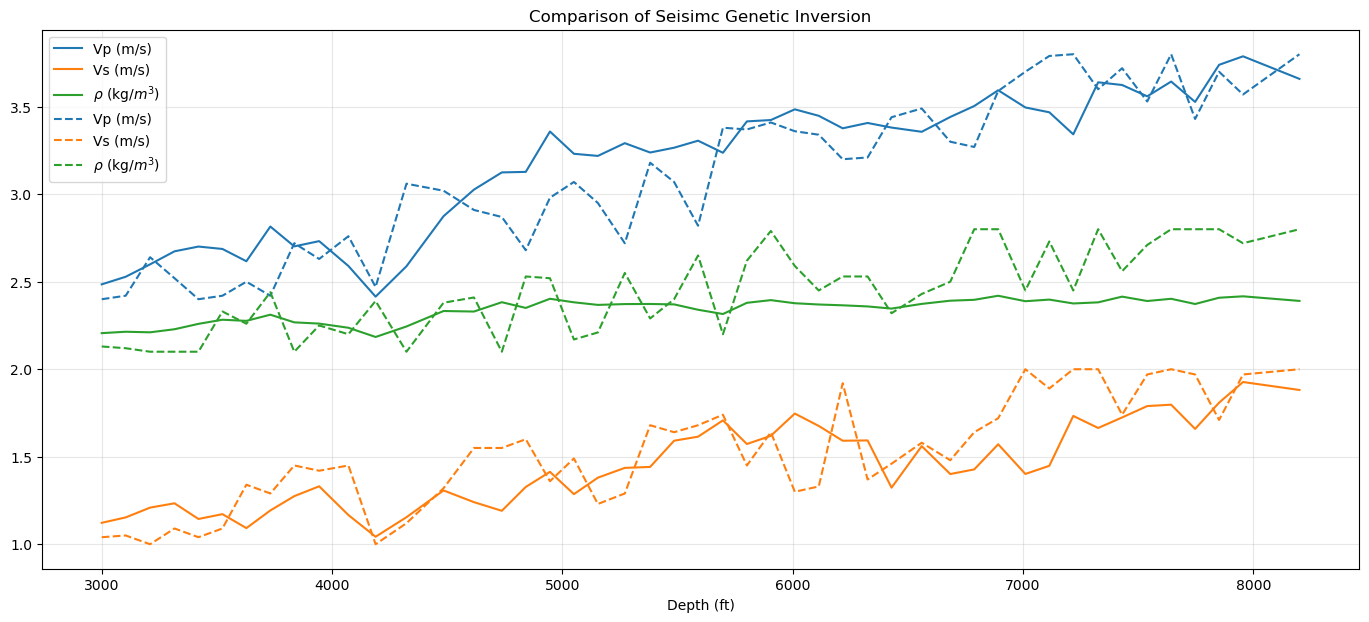

In [17]:
# Plot resmapled data
fig = plt.figure(figsize=(17,7))
plt.plot(dept0, vp0, label='Vp (m/s)', color='C0')
plt.plot(dept0, vs0, label='Vs (m/s)', color='C1')
plt.plot(dept0, rho0, label=fr'$\rho$ (kg/$m^3$)', color='C2')
plt.plot(dept0, best_model[:,1], label='Vp (m/s)', linestyle='dashed', color='C0')
plt.plot(dept0, best_model[:,2], label='Vs (m/s)', linestyle='dashed', color='C1')
plt.plot(dept0, best_model[:,0], label=fr'$\rho$ (kg/$m^3$)', linestyle='dashed', color='C2')
plt.xlabel('Depth (ft)')
plt.grid(alpha=.3)
plt.legend(ncol=1)
plt.title('Comparison of Seisimc Genetic Inversion')

Continuous lines represent the observed values, while dashed lines represent seismic inversion results obtained through genetic algorithms. The L1 error between the reflectivity profiles is small, at 5%. However, the inversion yields a significantly different model for Vp, Vs, and rho, highlighting the problem of non-uniqueness. Despite this non-uniqueness challenge, we achieve overall good results.

It has been demonstrated that constructing initial models that consider the depth data trend, along with the introduction of some random values to introduce model randomness, effectively aligns with the actual Vp, Vs, and rho of the subsurface. Specifically, the value of max_diff—set to 0.3 in this context—defines the maximum allowable difference between adjacent values. This hyperparameter proves to be crucial for the seismic genetic algorithm to perform effectively.